# In this notebook and next notebook series, I'm going to practice a powerful technique called transfer learning and be replicating a machine learning research paper.

Course practice: https://github.com/mrdbourke/pytorch-deep-learning

## Imports

In [ ]:
import torch
from torch.utils.data import DataLoader
from torch import nn

import torchvision
from torchvision import datasets, transforms

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from seaborn import heatmap

from pathlib import Path
import requests
import zipfile
import os
from tqdm.auto import tqdm
from timeit import default_timer as timer
from PIL import Image
import random
from typing import Tuple, Dict, List

In [ ]:
try:
    from torchinfo import summary
except:
    !pip install torchinfo
    from torchinfo import summary

## Usful class and basic setup

In [ ]:
class Helper():

    def __init__(self, device: torch.device):
        self.device = device

    def download_data(self,
                      source: str,
                      destination: str,
                      remove_source: bool=True) -> Path:

        # Path to data folder
        data_path = Path('data/')
        image_path = data_path / destination

        # If image folder doesn't exist, dowload and prepare it
        if image_path.is_dir():
            print(f'{image_path} is already exists')
        else:
            print(f'Did not find {image_path} directory, creating it')
            image_path.mkdir(parents=True, exist_ok=True)

            # Download data from source
            target_file = Path(source).name

            with open(data_path / target_file, 'wb') as f:
                request = requests.get(source)
                print(f'Downloading {target_file} form {source}')
                f.write(request.content)

            # Unzip data from target file:
            with zipfile.ZipFile(data_path / target_file, 'r') as zip:
                print(f'Unzipping {target_file}')
                zip.extractall(image_path)

            if remove_source:
                os.remove(data_path / target_file)

        return image_path

    def create_dataloaders(self,
                           train_dir: str,
                           test_dir: str,
                           transform: transforms.Compose,
                           batch_size: int,
                           num_workers: int=os.cpu_count()):

        # Create custom datasets by using ImageFolder
        train_dataset = datasets.ImageFolder(train_dir, transform=transform)
        test_dataset = datasets.ImageFolder(test_dir, transform=transform)

        # Get class names
        class_names = train_dataset.classes

        # Turn images into data loaders
        train_dataloader = DataLoader(dataset=train_dataset,
                                      batch_size=batch_size,
                                      shuffle=True,
                                      num_workers=num_workers,
                                      pin_memory=True
                                      )
        test_dataloader = DataLoader(dataset=test_dataset,
                                     batch_size=batch_size,
                                     shuffle=False,
                                     num_workers=num_workers,
                                     pin_memory=True)

        return train_dataloader, test_dataloader, class_names

    def set_seeds(self, seed: int=42):

        # Set the seed for general torch operations
        torch.manual_seed(seed)

        # Set the seed for CUDA torch operations (ones that happen on the GPU)
        torch.cuda.manual_seed(seed)

    def train_step(self,
                   model: torch.nn.Module,
                   dataloader: torch.utils.data.DataLoader,
                   loss_fn: torch.nn.Module,
                   optimizer: torch.optim.Optimizer,
                   device: torch.device) -> Tuple[float, float]:

        # Put model in train mode
        model.train()

        # Setup train loss and train accuracy
        train_loss, train_accuracy = 0, 0

        # Loop through data loader data batches
        for batch, (X, y) in enumerate(dataloader):

            # Send data to device
            X = X.to(device)
            y = y.to(device)

            # Forward pass
            y_pred = model(X)

            # Calculate loss
            loss = loss_fn(y_pred, y)
            train_loss += loss.item()

            # 3 must have
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Calculate accuracy
            y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
            train_accuracy += torch.eq(y_pred_class, y).sum().item() / len(y)

        # Adjust metrics to get average loss and accuracy per batch
        train_loss /= len(dataloader)
        train_accuracy /= len(dataloader)

        return train_loss, train_accuracy

    @torch.inference_mode()
    def test_step(self,
                  model: torch.nn.Module,
                  dataloader: torch.utils.data.DataLoader,
                  loss_fn: torch.nn.Module,
                  device: torch.device) -> Tuple[float, float]:

        # Put model in eval mode
        model.eval()

        # Setup test loss and test accuracy
        test_loss, test_accuracy = 0, 0

        # Loop through data loader data batches
        for batch, (X, y) in enumerate(dataloader):

            # Send data to device
            X = X.to(device)
            y = y.to(device)

            # Forward pass
            y_pred = model(X)

            # Calculate loss
            loss = loss_fn(y_pred, y)
            test_loss += loss.item()

            # Calculate accuracy
            y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
            test_accuracy += torch.eq(y_pred_class, y).sum().item() / len(y)

        # Adjust metrics to get average loss and accuracy per batch
        test_loss /= len(dataloader)
        test_accuracy /= len(dataloader)

        return test_loss, test_accuracy

    def train(self,
              model: torch.nn.Module,
              train_dataloader: torch.utils.data.DataLoader,
              test_dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              optimizer: torch.optim.Optimizer,
              epochs: int,
              device: torch.device) -> Dict[str, List[float]]:

        res = {'train_loss': [],
               'train_acc': [],
               'test_loss': [],
               'test_acc': []}

        # Loop through training and testing steps for a number of epochs
        for epoch in tqdm(range(epochs)):
            train_loss, train_accuracy = self.train_step(model=model,
                                                         dataloader=train_dataloader,
                                                         loss_fn=loss_fn,
                                                         optimizer=optimizer,
                                                         device=device)
            test_loss, test_accuracy = self.test_step(model=model,
                                                      dataloader=test_dataloader,
                                                      loss_fn=loss_fn,
                                                      device=device)

            # Logs
            print(f'Epoch: {epoch + 1} | '
                  f'train loss: {train_loss:.4f} | '
                  f'train accuracy: {train_accuracy:.4f} | '
                  f'test loss: {test_loss:.4f} | '
                  f'test accuracy: {test_accuracy:.4f}')

            # Update results
            res['train_loss'].append(train_loss)
            res['train_acc'].append(train_accuracy)
            res['test_loss'].append(test_loss)
            res['test_acc'].append(test_accuracy)

        return res

    def plot_loss_accuracy_curves(self, results: Dict[str, List[int]]):

        # Get train loss, test loss, train accuracy, test accuracy from dict
        train_loss = results['train_loss']
        train_accuracy = results['train_acc']
        test_loss = results['test_loss']
        test_accuracy = results['test_acc']

        # Figure out how many epochs there are
        epochs = range(len(train_loss))

        # Setup the plot
        plt.figure(figsize=(15, 7))

        # Plot loss
        plt.subplot(1, 2, 1)
        plt.plot(epochs, train_loss, label='Train loss')
        plt.plot(epochs, test_loss, label='Test loss')
        plt.title('Loss')
        plt.xlabel('Epochs')
        plt.legend()

        # Plot accuracy
        plt.subplot(1, 2, 2)
        plt.plot(epochs, train_accuracy, label='Train accuracy')
        plt.plot(epochs, test_accuracy, label='Test accuracy')
        plt.title('Accuracy')
        plt.xlabel('Epochs')
        plt.legend()

    @torch.inference_mode()
    def predict_and_mb_plot(self,
                            model: torch.nn.Module,
                            image_path: str,
                            class_names: List[str],
                            device: torch.device,
                            image_size: Tuple[int, int]=(224, 224),
                            transform: torchvision.transforms=None,
                            make_plot: bool=False):

        # Open Image
        image = Image.open(image_path)

        # Create transformation for image
        if transform:
            image_transform = transform
        else:
            image_transform = transform
            image_transform = torchvision.transforms.Compose([transforms.Resize(image_size),
                                                             transforms.ToTensor(),
                                                             transforms.Normalize(mean=[.485, .456, .406],
                                                                                  std=[.229, .224, .225])])

        # Predict label (class)
        # Make sure the model is on the target device
        model.to(device)

        # Put model to eval mode
        model.eval()

        # Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
        transformed_image = image_transform(image).unsqueeze(dim=0)

        # Calculate logits on image with an extra dimension and send it to the target device
        logits = model((transformed_image).to(device))

        # Calculate probability and make a prediction
        probability = torch.softmax(logits, dim=1)
        predicted = torch.argmax(probability, dim=1)

        # Plot image with predicted label and probability
        if make_plot:
            plt.figure()
            plt.imshow(image)
            plt.title(f'Pred: {class_names[predicted]} | Prob: {probability.max():.3f}')
            plt.axis(False)
        else:
            return predicted, torch.round(probability.max(), decimals=3)

    def save_model(self,
                   model: torch.nn.Module,
                   target_dir: str,
                   model_name: str):

        # Create target directory
        target_dir_path = Path(target_dir)
        target_dir_path.mkdir(parents=True,
                              exist_ok=True)

        # Create model save path
        assert model_name.endswith(".pth") or model_name.endswith(".pt"), "model_name should end with '.pt' or '.pth'"
        model_save_path = target_dir_path / model_name

        # Save model's state_dict()
        print(f'Model saved in {model_save_path}')
        torch.save(obj=model.state_dict(),
                   f=model_save_path)

    @torch.inference_mode()
    def make_prediction(self,
                        model: torch.nn.Module,
                        data: list,
                        device: torch.device) -> torch.Tensor:

        probs, preds = [], []
        model.eval()
        if type(data[0]) is tuple:
            data = [data[i][0] for i in range(len(data))]
        for sample in data:
            # Add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
            sample = torch.unsqueeze(sample, dim=0).to(device)
            # Calculate logits on image with an extra dimension and send it to the target device
            logits = model(sample)
            # Calculate probability
            probability = torch.softmax(logits, dim=1)
            probs.append(probability.cpu())
            predicted = torch.argmax(probability, dim=1)
            preds.append(predicted.cpu())

        # Stack probabilities and predictions into tensors
        probs = torch.cat(probs, dim=0)
        preds = torch.cat(preds, dim=0)

        return probs, preds

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
helper = Helper(device)

In [ ]:
# Create global variables
BATCH_SIZE = 32
NUM_CLASSES = 3
IMG_SIZE = 224
OUT_SHAPE = 768

## Block 0: simple CV model - TinyVGG from the CNN Explainer website

In [ ]:
# Create class TinyVGG

class TinyVGG(nn.Module):

    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int):
        super().__init__()

        # Initialization of the model parameters
        self.input_shape = input_shape
        self.hidden_units = hidden_units
        self.ouput_shape = output_shape

        # Create model architecture
        self.conv_block_1 = nn.Sequential(nn.Conv2d(in_channels=self.input_shape,
                                                    out_channels=self.hidden_units,
                                                    kernel_size=3,
                                                    stride=1,
                                                    padding=1),
                                          nn.ReLU(),
                                          nn.Conv2d(in_channels=self.hidden_units,
                                                    out_channels=self.hidden_units,
                                                    kernel_size=3,
                                                    stride=1,
                                                    padding=1),
                                          nn.MaxPool2d(kernel_size=2,
                                                       stride=2))
        self.conv_block_2 = nn.Sequential(nn.Conv2d(in_channels=self.hidden_units,
                                                    out_channels=self.hidden_units,
                                                    kernel_size=3,
                                                    stride=1,
                                                    padding=1),
                                          nn.ReLU(),
                                          nn.Conv2d(in_channels=self.hidden_units,
                                                    out_channels=self.hidden_units,
                                                    kernel_size=3,
                                                    stride=1,
                                                    padding=1),
                                          nn.MaxPool2d(kernel_size=2,
                                                       stride=2))
        self.classifier = nn.Sequential(nn.Flatten(),
                                        nn.Linear(in_features=self.hidden_units*7*7,  # After flatting
                                                  out_features=self.ouput_shape))

    # Forward pass
    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        return self.classifier(x)

In [ ]:
# Setup trianing and testing data
train_data = datasets.FashionMNIST(root='data',
                                   train=True,
                                   transform=transforms.ToTensor(),
                                   target_transform=None,
                                   download=True)
test_data = datasets.FashionMNIST(root='data',
                                  train=False,
                                  transform=transforms.ToTensor(),
                                  target_transform=None,
                                  download=True)

100%|██████████| 26421880/26421880 [00:08<00:00, 3117893.52it/s] 


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 277563.27it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5133459.28it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 3844094.18it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [ ]:
# Get image size
image = train_data[0][0]
image.shape

torch.Size([1, 28, 28])

In [ ]:
# Get class names
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

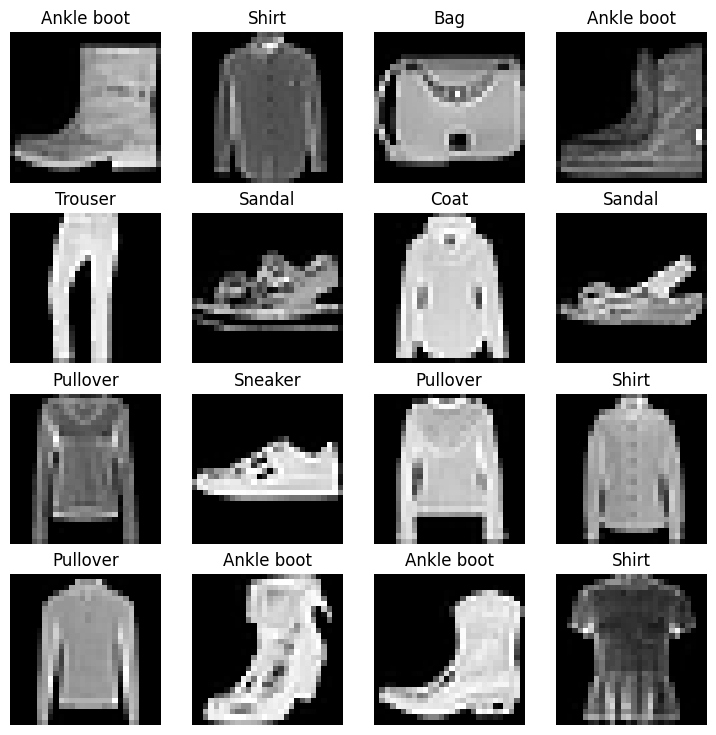

In [ ]:
# Plot images
helper.set_seeds()
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    image, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title(class_names[label])
    plt.axis(False)

In [ ]:
# Create data loaders
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)
test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False)
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Length of train dataloader: 1875 batches of 32
Length of test dataloader: 313 batches of 32


In [ ]:
# Create model
helper.set_seeds()
model = TinyVGG(input_shape=1,
                hidden_units=16,
                output_shape=len(class_names)).to(device)
model

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
  )
)

In [ ]:
# Define loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=1e-3)

In [ ]:
# Train model
helper.set_seeds()
start = timer()
res = helper.train(model=model,
                   train_dataloader=train_dataloader,
                   test_dataloader=test_dataloader,
                   loss_fn=loss_fn,
                   optimizer=optimizer,
                   epochs=5,
                   device=device)
print(timer() - start)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train loss: 2.2798 | train accuracy: 0.1558 | test loss: 2.1974 | test accuracy: 0.1668
Epoch: 2 | train loss: 1.1585 | train accuracy: 0.6115 | test loss: 0.7726 | test accuracy: 0.7057
Epoch: 3 | train loss: 0.7030 | train accuracy: 0.7479 | test loss: 0.6748 | test accuracy: 0.7677
Epoch: 4 | train loss: 0.6423 | train accuracy: 0.7722 | test loss: 0.6251 | test accuracy: 0.7775
Epoch: 5 | train loss: 0.6052 | train accuracy: 0.7825 | test loss: 0.5974 | test accuracy: 0.7858
341.27072026499997


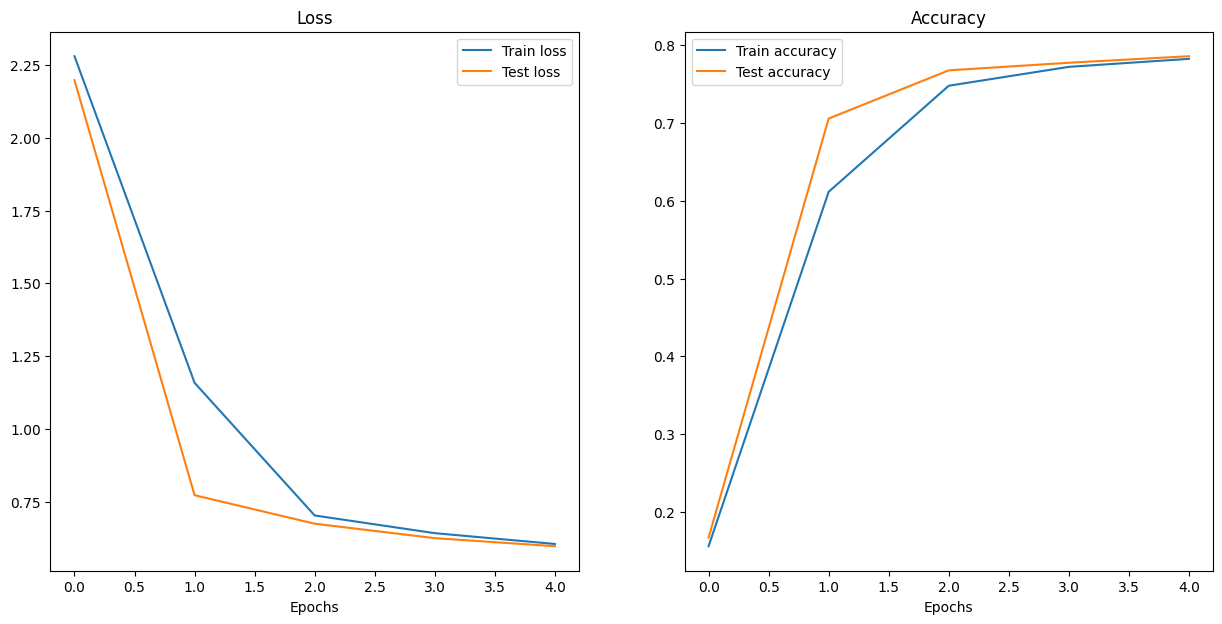

In [ ]:
helper.plot_loss_accuracy_curves(results=res)

In [ ]:
# Choose test samples
helper.set_seeds()
test_samples, test_labels = [], []
n = 9
for sample, label in random.sample(list(test_data), k=n):
    test_samples.append(sample)
    test_labels.append(label)

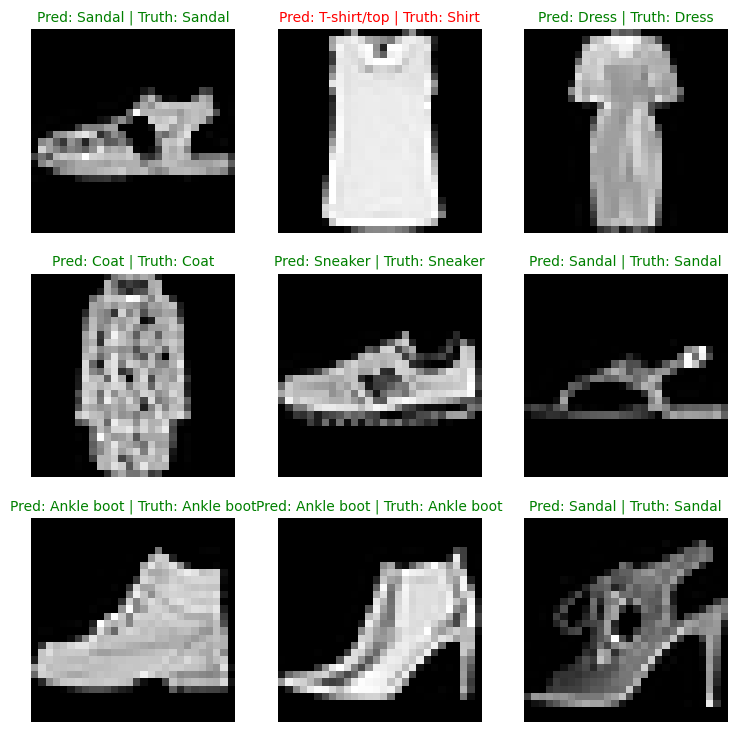

In [ ]:
# Make and plot predictions on random samples
res = helper.make_prediction(model=model, data=test_samples, device=device)

plt.figure(figsize=(9, 9))
rows, cols = 3, 3
for i, sample in enumerate(test_samples):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(sample.squeeze(), cmap='gray')
    pred_label = class_names[res[1][i]]
    truth_label = class_names[test_labels[i]]
    title_text = f"Pred: {pred_label} | Truth: {truth_label}"
    if pred_label == truth_label:
        plt.title(title_text, fontsize=10, c="g")
    else:
        plt.title(title_text, fontsize=10, c="r")
    plt.axis(False)

In [ ]:
# Make predictions on full test dataset and build confusion matrix
pred_labels = helper.make_prediction(model=model, data=list(test_data), device=device)

<Axes: >

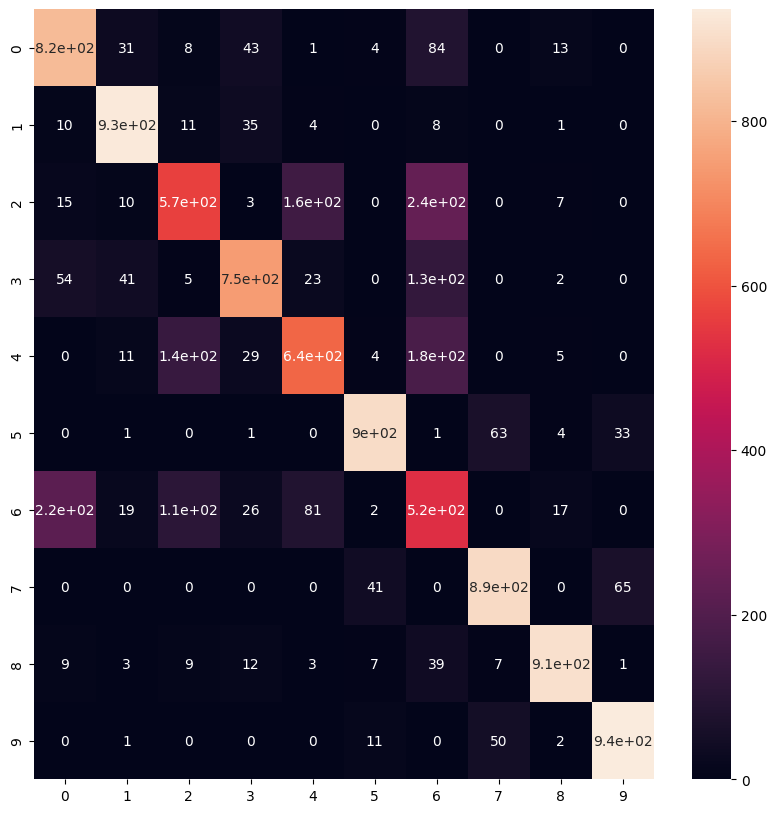

In [ ]:
plt.figure(figsize=(10, 10))
# heatmap(confusion_matrix(y_true=test_data.targets.numpy(), y_pred=pred_labels[1].numpy()), annot=True)
heatmap(confusion_matrix(y_true=test_data.targets.numpy(), y_pred=pred_labels[1].numpy()), annot=True)